In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import xgboost as xgb

In [3]:
df = pd.read_pickle('../../data/Backtesting/r2k_qfl_data_20y_m.pkl')
df= df.reset_index()
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index(['DATE',"UNIVERSE"])

df = df[df['1m_fwd_ret'].isna()==False]

x1 =df[['market_val','fcfy','bp','dy','peg','ey','ocfy','debt_to_assets','curr_ration','cfroic','res_ret_mom']]

y = df['1m_fwd_ret']

In [6]:
# Convert 'date' to datetime if it's not

# Define a function to fill NA with median
def fill_na_with_median(data):
    return data.fillna(data.median())

# Apply it across the data
X = x1.groupby('DATE').transform(fill_na_with_median)

In [7]:
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

import numpy as np
rng = np.random.RandomState(1994)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rng)

# Fit linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

# Fit random forest model
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# Fit decision tree model
dt_model = DecisionTreeRegressor(max_depth = 3)
dt_model.fit(X_train, y_train)
dt_preds = dt_model.predict(X_test)

# Fit decision tree model
dt_modeln = DecisionTreeRegressor()
dt_modeln.fit(X_train, y_train)
dt_predsn = dt_modeln.predict(X_test)

# Fit neural network model
nn_model = MLPRegressor()
nn_model.fit(X_train, y_train)
nn_preds = nn_model.predict(X_test)

# Evaluate model performance
# Evaluate model performance
df_model_results = pd.DataFrame([['Linear Regression:', round(mean_squared_error(y_test, lr_preds, squared=False),4)],
                                ['Random Forest Regressor:', round(mean_squared_error(y_test, rf_preds, squared=False),4)],
                                ['Decision Tree Regressor (3):', round(mean_squared_error(y_test, dt_preds, squared=False),4)],
                                ['Decision Tree Regressor (n):', round(mean_squared_error(y_test, dt_predsn, squared=False),4)],
                                ['Neural Network Regressor:', round(mean_squared_error(y_test, nn_preds, squared=False),4)]],
                                columns= ['Model','RMSE']).set_index('Model').sort_values('RMSE')

df_model_results

,RMSE
Model,
Random Forest Regressor:,44.3266
Linear Regression:,46.5899
Neural Network Regressor:,50.6126
Decision Tree Regressor (3):,54.9041
Decision Tree Regressor (n):,57.9968


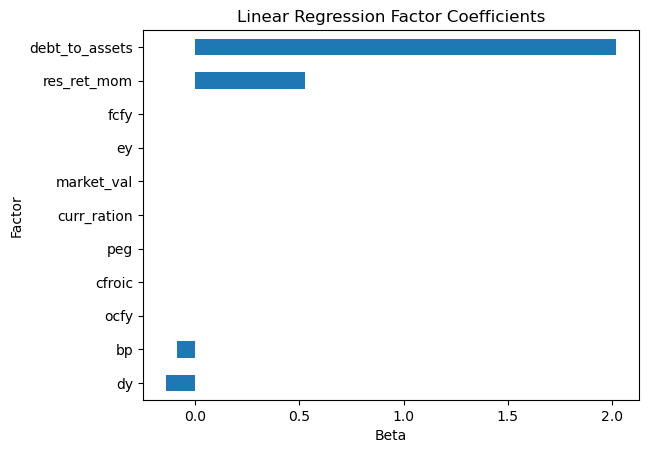

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

lr_s = pd.Series(lr_model.coef_,index = X.columns).sort_values()

lr_s.plot(kind ='barh')

plt.title('Linear Regression Factor Coefficients')

plt.ylabel('Factor')

plt.xlabel('Beta')

plt.show()

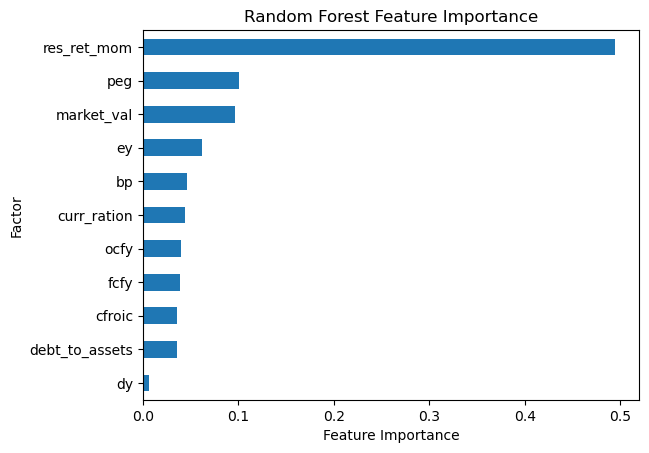

In [9]:
rf_s = pd.Series(rf_model.feature_importances_,index = X.columns).sort_values()

rf_s.plot(kind ='barh')

plt.title('Random Forest Feature Importance')

plt.xlabel('Feature Importance')

plt.ylabel('Factor')

plt.show()

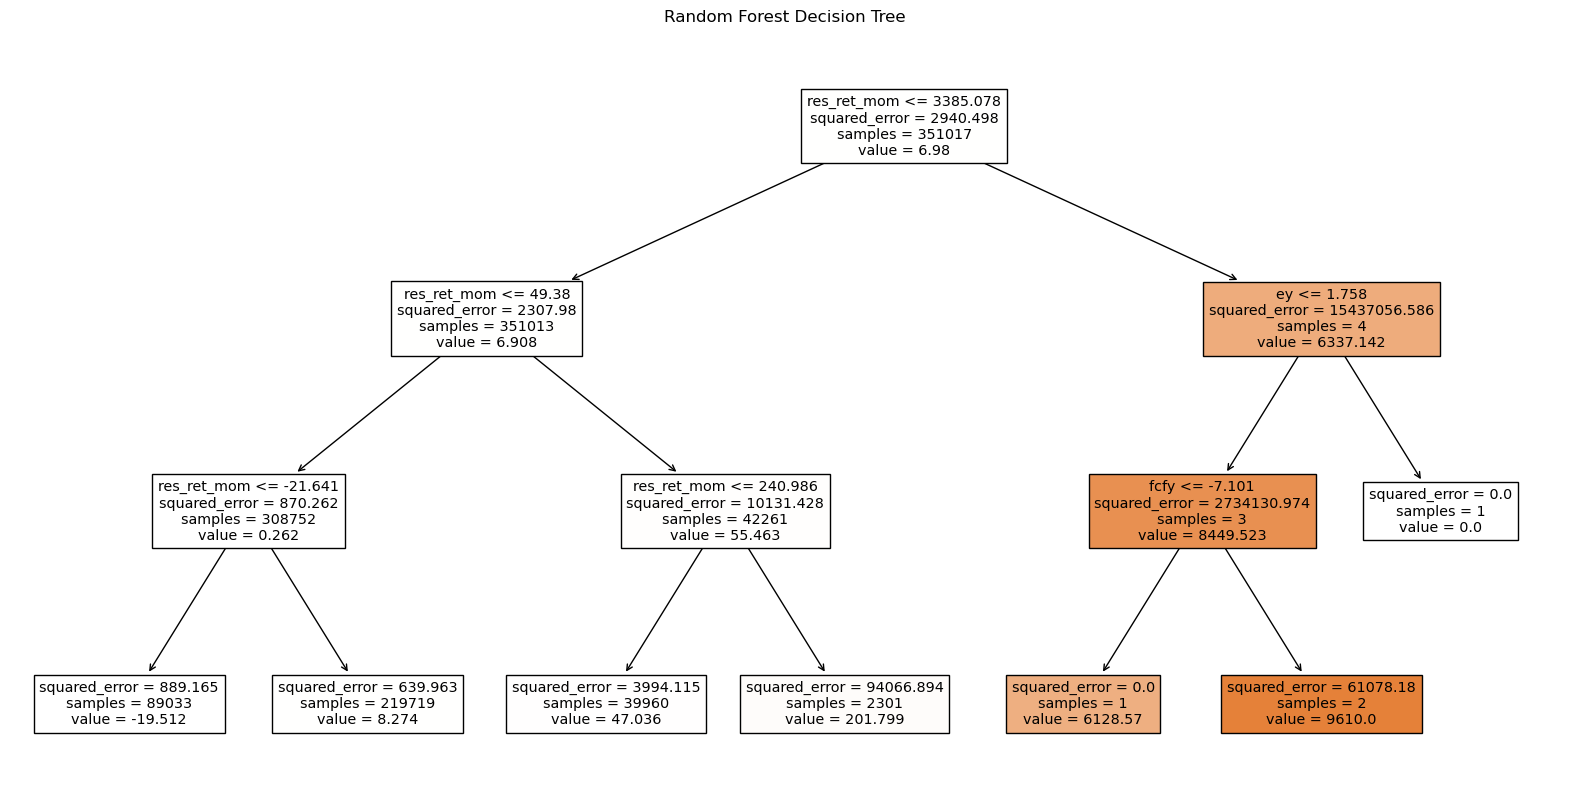

In [10]:
from sklearn import tree
factors = X_train.columns
fig,ax= plt.subplots(figsize= (20,10))
tree.plot_tree(dt_model,
           feature_names = factors, 
           filled = True)


plt.title('Random Forest Decision Tree')

plt.show()

In [11]:

# Generate a synthetic dataset for demo, the generate process is from the sklearn
# example.
# Train on 0.05 and 0.95 quantiles. The model is similar to multi-class and
# multi-target models.
alpha = np.array([0.05, 0.5, 0.95])
evals_result= {}


# We will be using the `hist` tree method, quantile DMatrix can be used to preserve
# memory.
# Do not use the `exact` tree method for quantile regression, otherwise the
# performance might drop.
Xy = xgb.QuantileDMatrix(X, y)
# use Xy as a reference
Xy_test = xgb.QuantileDMatrix(X_test, y_test, ref=Xy)

booster = xgb.train(
    {
        # Use the quantile objective function.
        "objective": "reg:quantileerror",
        "tree_method": "hist",
        "quantile_alpha": alpha,
        # Let's try not to overfit.
        "learning_rate": 0.04,
        "max_depth": 5,
    },
    Xy,
    num_boost_round=100,
    early_stopping_rounds=2,
    # The evaluation result is a weighted average across multiple quantiles.
    evals=[(Xy, "Train"), (Xy_test, "Test")],
    evals_result=evals_result,
)

[0]	Train-quantile:11.61773	Test-quantile:11.82730
[1]	Train-quantile:10.94352	Test-quantile:11.18545
[2]	Train-quantile:10.35156	Test-quantile:10.60627
[3]	Train-quantile:9.80299	Test-quantile:10.08049
[4]	Train-quantile:9.32427	Test-quantile:9.61004
[5]	Train-quantile:8.91743	Test-quantile:9.19725
[6]	Train-quantile:8.54268	Test-quantile:8.82919
[7]	Train-quantile:8.19951	Test-quantile:8.49331
[8]	Train-quantile:7.89524	Test-quantile:8.19282
[9]	Train-quantile:7.63258	Test-quantile:7.92880
[10]	Train-quantile:7.38495	Test-quantile:7.68457
[11]	Train-quantile:7.17186	Test-quantile:7.46595
[12]	Train-quantile:6.97331	Test-quantile:7.26492
[13]	Train-quantile:6.79249	Test-quantile:7.08138
[14]	Train-quantile:6.63849	Test-quantile:6.91941
[15]	Train-quantile:6.49279	Test-quantile:6.76803
[16]	Train-quantile:6.36279	Test-quantile:6.63321
[17]	Train-quantile:6.24212	Test-quantile:6.50767
[18]	Train-quantile:6.14185	Test-quantile:6.39541
[19]	Train-quantile:6.04306	Test-quantile:6.29017
[20

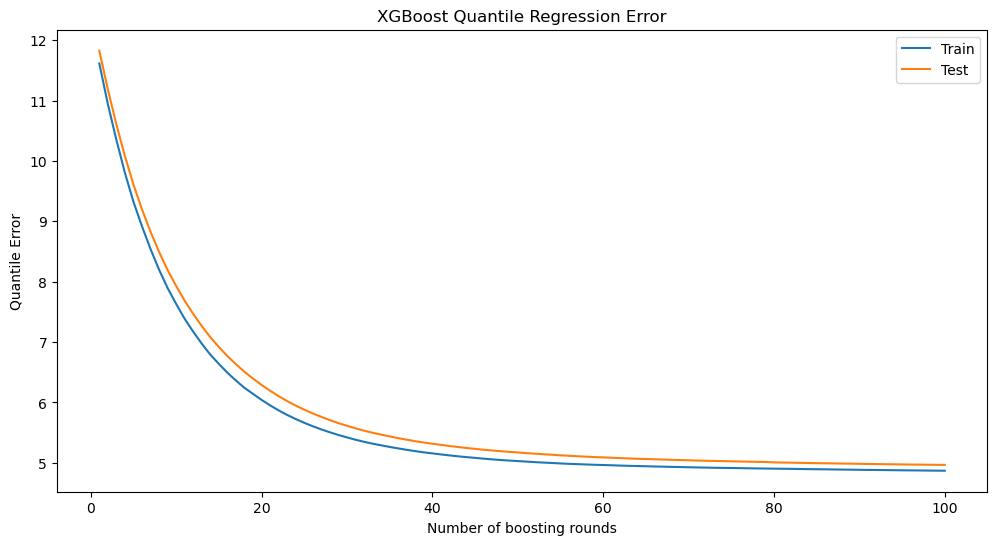

In [12]:
import matplotlib.pyplot as plt

# Get metric values from evals_result
train_metric = evals_result['Train']['quantile']
test_metric = evals_result['Test']['quantile']

# Create a range (x-axis) for number of boosting rounds
x_values = range(1, len(train_metric) + 1)

# Start figure
fig, ax = plt.subplots(figsize=(12,6))

# Plot values
ax.plot(x_values, train_metric, label='Train')
ax.plot(x_values, test_metric, label='Test')

# Add title and labels
ax.set_title('XGBoost Quantile Regression Error')
ax.set_xlabel('Number of boosting rounds')
ax.set_ylabel('Quantile Error')

# Add legend
ax.legend()

# Display plot
plt.show()

In [13]:
# Predict using the trained model
preds = booster.predict(Xy)
preds

array([[ -4.4368773,  42.421062 , 157.55727  ],
       [ -7.6171865,  10.53597  ,  39.309685 ],
       [ -2.5405252,  20.966354 ,  69.33305  ],
       ...,
       [-53.388893 , -26.53007  ,  22.797184 ],
       [-33.006252 ,   8.882585 ,  64.427246 ],
       [-25.285995 ,   6.0498304,  64.24879  ]], dtype=float32)

In [14]:
X['quantile_0.05'] = preds[:, 0]
X['quantile_0.50'] = preds[:, 1]
X['quantile_0.95'] = preds[:, 2]
X

market_val       fcfy        bp        dy        peg  \
DATE       UNIVERSE                                                          
2000-12-29 CORSQ      672.505000   3.699401  0.525311  1.202400   1.483637   
           MCS        335.384151 -11.905992  0.858255  1.585586  10.502121   
           HAR       1278.264023   5.672346  0.307900  0.273973   2.277045   
           BANF       335.239983   5.910332  0.541935  1.662992   0.816189   
           LANC      1041.489053   8.756591  0.386595  2.316258   1.099718   
...                          ...        ...       ...       ...        ...   
2020-12-31 ADEA      2149.036191   8.629018  0.584158  0.956938   1.757202   
           SEAC        50.700690 -21.748438  0.667783  0.000000   1.757202   
           CBUS       157.526437 -25.469511  0.223100  0.000000   1.757202   
           NBSE       162.243133  -7.053142  0.193163  0.000000   1.757202   
           HARP       493.647652   9.565017  0.144086  0.000000   1.757202   

                            ey       ocfy  debt_to_assets  curr_ration  \
DATE       UNIVERSE                                                      
2000-12-29 CORSQ      7.763919   3.908794        0.036491     1.629756   
           MCS        5.057919  13.979033        0.423888     0.402932   
           HAR        5.479234  12.253198        0.243800     1.856838   
           BANF       7.613773   9.033106        0.036287     5.371699   
           LANC       8.918365  10.893912        0.022234     3.274372   
...                        ...        ...             ...          ...   
2020-12-31 ADEA      -2.219763   8.802467        0.408832     2.477170   
           SEAC     -33.161850 -21.101784        0.150393     2.297560   
           CBUS     -27.878492 -24.461292        0.318528     4.832302   
           NBSE     -10.730432  -6.610691        0.004023    10.416623   
           HARP     -12.529428   9.800803        0.076658     3.488389   

                        cfroic  res_ret_mom  quantile_0.05  quantile_0.50  \
DATE       UNIVERSE                                                         
2000-12-29 CORSQ      7.219852   127.494225      -4.436877      42.421062   
           MCS        9.027527    18.455162      -7.617187      10.535970   
           HAR       21.761690    38.165245      -2.540525      20.966354   
           BANF      13.556413    32.523865     -12.734898       9.748556   
           LANC      28.212130    -6.679672     -16.570370       0.175412   
...                        ...          ...            ...            ...   
2020-12-31 ADEA      12.993757     2.121711     -10.379505       9.478041   
           SEAC     -23.111887   -68.807110     -69.281509     -45.559250   
           CBUS     -53.205605   -53.127075     -53.388893     -26.530069   
           NBSE     -61.534245     1.977014     -33.006252       8.882585   
           HARP      42.655357    -2.426529     -25.285995       6.049830   

                     quantile_0.95  
DATE       UNIVERSE                 
2000-12-29 CORSQ        157.557266  
           MCS           39.309685  
           HAR           69.333054  
           BANF          48.466110  
           LANC          22.938375  
...                            ...  
2020-12-31 ADEA          41.659657  
           SEAC          14.976451  
           CBUS          22.797184  
           NBSE          64.427246  
           HARP          64.248787  

[468023 rows x 14 columns]

In [15]:
df_f= X.join(y)
df_f

market_val       fcfy        bp        dy        peg  \
DATE       UNIVERSE                                                          
2000-12-29 CORSQ      672.505000   3.699401  0.525311  1.202400   1.483637   
           MCS        335.384151 -11.905992  0.858255  1.585586  10.502121   
           HAR       1278.264023   5.672346  0.307900  0.273973   2.277045   
           BANF       335.239983   5.910332  0.541935  1.662992   0.816189   
           LANC      1041.489053   8.756591  0.386595  2.316258   1.099718   
...                          ...        ...       ...       ...        ...   
2020-12-31 ADEA      2149.036191   8.629018  0.584158  0.956938   1.757202   
           SEAC        50.700690 -21.748438  0.667783  0.000000   1.757202   
           CBUS       157.526437 -25.469511  0.223100  0.000000   1.757202   
           NBSE       162.243133  -7.053142  0.193163  0.000000   1.757202   
           HARP       493.647652   9.565017  0.144086  0.000000   1.757202   

                            ey       ocfy  debt_to_assets  curr_ration  \
DATE       UNIVERSE                                                      
2000-12-29 CORSQ      7.763919   3.908794        0.036491     1.629756   
           MCS        5.057919  13.979033        0.423888     0.402932   
           HAR        5.479234  12.253198        0.243800     1.856838   
           BANF       7.613773   9.033106        0.036287     5.371699   
           LANC       8.918365  10.893912        0.022234     3.274372   
...                        ...        ...             ...          ...   
2020-12-31 ADEA      -2.219763   8.802467        0.408832     2.477170   
           SEAC     -33.161850 -21.101784        0.150393     2.297560   
           CBUS     -27.878492 -24.461292        0.318528     4.832302   
           NBSE     -10.730432  -6.610691        0.004023    10.416623   
           HARP     -12.529428   9.800803        0.076658     3.488389   

                        cfroic  res_ret_mom  quantile_0.05  quantile_0.50  \
DATE       UNIVERSE                                                         
2000-12-29 CORSQ      7.219852   127.494225      -4.436877      42.421062   
           MCS        9.027527    18.455162      -7.617187      10.535970   
           HAR       21.761690    38.165245      -2.540525      20.966354   
           BANF      13.556413    32.523865     -12.734898       9.748556   
           LANC      28.212130    -6.679672     -16.570370       0.175412   
...                        ...          ...            ...            ...   
2020-12-31 ADEA      12.993757     2.121711     -10.379505       9.478041   
           SEAC     -23.111887   -68.807110     -69.281509     -45.559250   
           CBUS     -53.205605   -53.127075     -53.388893     -26.530069   
           NBSE     -61.534245     1.977014     -33.006252       8.882585   
           HARP      42.655357    -2.426529     -25.285995       6.049830   

                     quantile_0.95  1m_fwd_ret  
DATE       UNIVERSE                             
2000-12-29 CORSQ        157.557266   101.83100  
           MCS           39.309685    26.20220  
           HAR           69.333054    25.39610  
           BANF          48.466110    42.82300  
           LANC          22.938375    -9.56693  
...                            ...         ...  
2020-12-31 ADEA          41.659657    33.00190  
           SEAC          14.976451   -68.46850  
           CBUS          22.797184   -24.23700  
           NBSE          64.427246     9.73312  
           HARP          64.248787    24.98120  

[468023 rows x 15 columns]

In [20]:
X=x1.dropna()
df_comp = {}
lr_preds_mfr = lr_model.predict(X)
df_comp['linear_reg_mfr'] =pd.Series(lr_preds_mfr,index = X.index)

rf_preds_mfr = rf_model.predict(X)
df_comp['random_forest_mfr'] =pd.Series(rf_preds_mfr,index = X.index)

dt_preds_mfr = dt_modeln.predict(X)
df_comp['decision_tree_mfr'] =pd.Series(dt_preds_mfr,index = X.index)
nn_preds_mfr = nn_model.predict(X)
df_comp['neural_net_mfr'] =pd.Series(nn_preds_mfr,index = X.index)
#


In [24]:
df_final = df_f.join(pd.DataFrame.from_dict(df_comp),how='left')

In [60]:
df_final

market_val       fcfy        bp        dy        peg  \
DATE       UNIVERSE                                                          
2000-12-29 CORSQ      672.505000   3.699401  0.525311  1.202400   1.483637   
           MCS        335.384151 -11.905992  0.858255  1.585586  10.502121   
           HAR       1278.264023   5.672346  0.307900  0.273973   2.277045   
           BANF       335.239983   5.910332  0.541935  1.662992   0.816189   
           LANC      1041.489053   8.756591  0.386595  2.316258   1.099718   
...                          ...        ...       ...       ...        ...   
2020-12-31 ADEA      2149.036191   8.629018  0.584158  0.956938   1.757202   
           SEAC        50.700690 -21.748438  0.667783  0.000000   1.757202   
           CBUS       157.526437 -25.469511  0.223100  0.000000   1.757202   
           NBSE       162.243133  -7.053142  0.193163  0.000000   1.757202   
           HARP       493.647652   9.565017  0.144086  0.000000   1.757202   

                            ey       ocfy  debt_to_assets  curr_ration  \
DATE       UNIVERSE                                                      
2000-12-29 CORSQ      7.763919   3.908794        0.036491     1.629756   
           MCS        5.057919  13.979033        0.423888     0.402932   
           HAR        5.479234  12.253198        0.243800     1.856838   
           BANF       7.613773   9.033106        0.036287     5.371699   
           LANC       8.918365  10.893912        0.022234     3.274372   
...                        ...        ...             ...          ...   
2020-12-31 ADEA      -2.219763   8.802467        0.408832     2.477170   
           SEAC     -33.161850 -21.101784        0.150393     2.297560   
           CBUS     -27.878492 -24.461292        0.318528     4.832302   
           NBSE     -10.730432  -6.610691        0.004023    10.416623   
           HARP     -12.529428   9.800803        0.076658     3.488389   

                        cfroic  res_ret_mom  quantile_0.05  quantile_0.50  \
DATE       UNIVERSE                                                         
2000-12-29 CORSQ      7.219852   127.494225      -4.436877      42.421062   
           MCS        9.027527    18.455162      -7.617187      10.535970   
           HAR       21.761690    38.165245      -2.540525      20.966354   
           BANF      13.556413    32.523865     -12.734898       9.748556   
           LANC      28.212130    -6.679672     -16.570370       0.175412   
...                        ...          ...            ...            ...   
2020-12-31 ADEA      12.993757     2.121711     -10.379505       9.478041   
           SEAC     -23.111887   -68.807110     -69.281509     -45.559250   
           CBUS     -53.205605   -53.127075     -53.388893     -26.530069   
           NBSE     -61.534245     1.977014     -33.006252       8.882585   
           HARP      42.655357    -2.426529     -25.285995       6.049830   

                     quantile_0.95  1m_fwd_ret  linear_reg_mfr  \
DATE       UNIVERSE                                              
2000-12-29 CORSQ        157.557266   101.83100       70.529484   
           MCS           39.309685    26.20220       13.183457   
           HAR           69.333054    25.39610       24.378567   
           BANF          48.466110    42.82300       19.897251   
           LANC          22.938375    -9.56693       -0.303334   
...                            ...         ...             ...   
2020-12-31 ADEA          41.659657    33.00190             NaN   
           SEAC          14.976451   -68.46850             NaN   
           CBUS          22.797184   -24.23700             NaN   
           NBSE          64.427246     9.73312             NaN   
           HARP          64.248787    24.98120             NaN   

                     random_forest_mfr  decision_tree_mfr  neural_net_mfr  
DATE       UNIVERSE                                                        
2000-12-29 CORSQ             75

In [67]:
N = 250  # The number of stocks to hold in the portfolio
strategies = {}
# Define a function to select top/bottom N stocks for each date
# Select top/bottom N stocks for each date
def select_stocks(df,column):
    df = df.sort_values(column, ascending=False)
    top_stocks = df.head(N).copy()  # Take a copy to keep the original data unchanged
    top_stocks['strategy'] = 'long'  # Add 'strategy' column
    bottom_stocks = df.tail(N).copy()   # Take a copy to keep the original data unchanged
    bottom_stocks['strategy'] = 'short'  # Add 'strategy' column
    return pd.concat([top_stocks, bottom_stocks])

for strat in ['quantile_0.50','linear_reg_mfr','random_forest_mfr','decision_tree_mfr','neural_net_mfr']:
    temp= df_final.groupby(df_final.index.get_level_values('DATE')).apply(lambda x: select_stocks(x,column=strat))
    dates = temp.index.get_level_values(0)
    symbols =temp.index.get_level_values('UNIVERSE')

    # Create a list of arrays instead of a DataFrame
    new_index = list(zip(dates, symbols))

    # Assign it as new MultiIndex
    temp.index = pd.MultiIndex.from_tuples(new_index, names=['DATE', 'UNIVERSE'])

    strategies[strat]=temp

In [68]:
strategies[strat]

market_val       fcfy        bp        dy        peg  \
DATE       UNIVERSE                                                          
2000-12-29 ARXX      1421.552016   1.099093  0.125722  0.000000  11.648356   
           IMPHQ      958.072513   0.200662  0.125759  0.000000   1.781963   
           LH        5145.367828   2.838785  0.136301  0.000000   3.517965   
           CHKAQ     1368.963003   0.532439 -0.049060  0.000000   0.173275   
           XTO       2071.578413  27.368120  0.135906  0.144144   0.730144   
...                          ...        ...       ...       ...        ...   
2020-12-31 ADEA      2149.036191   8.629018  0.584158  0.956938   1.757202   
           SEAC        50.700690 -21.748438  0.667783  0.000000   1.757202   
           CBUS       157.526437 -25.469511  0.223100  0.000000   1.757202   
           NBSE       162.243133  -7.053142  0.193163  0.000000   1.757202   
           HARP       493.647652   9.565017  0.144086  0.000000   1.757202   

                            ey       ocfy  debt_to_assets  curr_ration  \
DATE       UNIVERSE                                                      
2000-12-29 ARXX       0.987928   1.665255        0.056215     5.633036   
           IMPHQ      1.062073   0.692794        0.177846     3.456422   
           LH         1.722556   3.745823        0.324496     1.784750   
           CHKAQ      8.212477  14.648233        1.003106     1.023131   
           XTO        3.368076  13.651824        0.680762     1.034365   
...                        ...        ...             ...          ...   
2020-12-31 ADEA      -2.219763   8.802467        0.408832     2.477170   
           SEAC     -33.161850 -21.101784        0.150393     2.297560   
           CBUS     -27.878492 -24.461292        0.318528     4.832302   
           NBSE     -10.730432  -6.610691        0.004023    10.416623   
           HARP     -12.529428   9.800803        0.076658     3.488389   

                        cfroic  res_ret_mom  quantile_0.05  quantile_0.50  \
DATE       UNIVERSE                                                         
2000-12-29 ARXX      16.718912   739.296600      -5.008738     128.811157   
           IMPHQ      5.171379   513.908140      -5.224047     135.555069   
           LH        17.222464   441.892430      -1.608028     130.405884   
           CHKAQ     28.232195   398.647640      -7.991377     110.672462   
           XTO       23.019754   371.963780      -4.917844      98.228645   
...                        ...          ...            ...            ...   
2020-12-31 ADEA      12.993757     2.121711     -10.379505       9.478041   
           SEAC     -23.111887   -68.807110     -69.281509     -45.559250   
           CBUS     -53.205605   -53.127075     -53.388893     -26.530069   
           NBSE     -61.534245     1.977014     -33.006252       8.882585   
           HARP      42.655357    -2.426529     -25.285995       6.049830   

                     quantile_0.95  1m_fwd_ret  linear_reg_mfr  \
DATE       UNIVERSE                                              
2000-12-29 ARXX         551.675110   506.90800      395.149128   
           IMPHQ        565.901550   501.13000      275.722159   
           LH           553.214478   431.32100      241.782903   
           CHKAQ        603.781860   305.00000      216.780299   
           XTO          454.632904   420.93800      202.671813   
...                            ...         ...             ...   
2020-12-31 ADEA          41.659657    33.00190             NaN   
           SEAC          14.976451   -68.46850             NaN   
           CBUS          22.797184   -24.23700             NaN   
           NBSE          64.427246     9.73312             NaN   
           HARP          64.248787    24.98120             NaN   

                     random_forest_mfr  decision_tree_mfr  neural_net_mfr  \
DATE       UNIVERSE                                                         
2000-12-29 ARXX             5

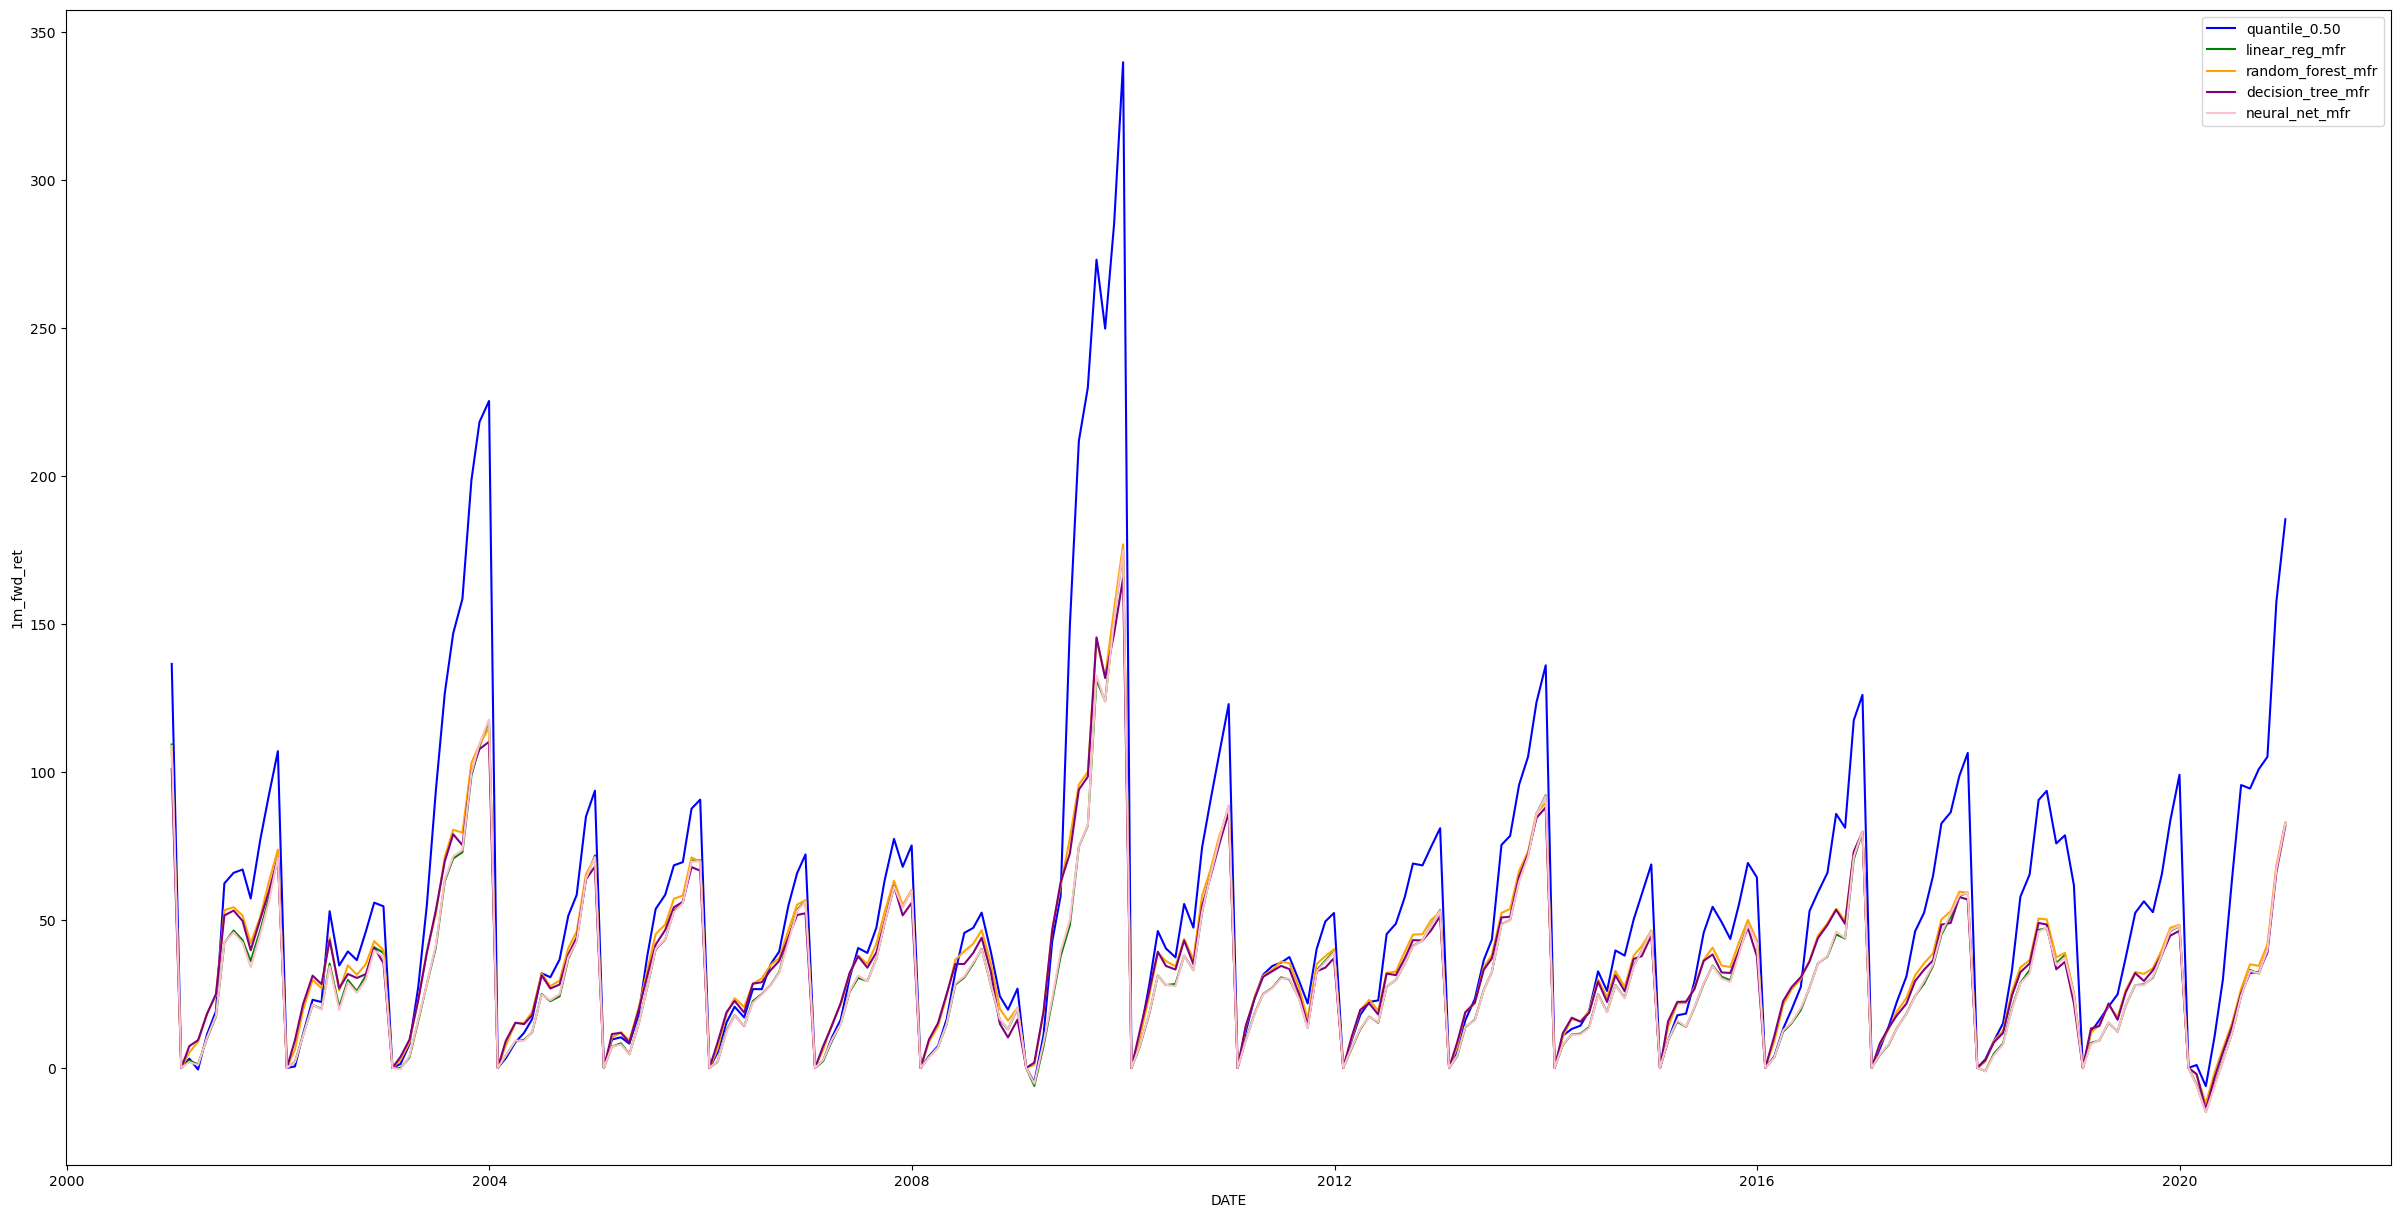

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize = (30,15))

# Define a list of colors
colors = ['blue', 'green', 'orange', 'purple', 'pink']
s_list = ['quantile_0.50','linear_reg_mfr','random_forest_mfr','decision_tree_mfr','neural_net_mfr']
for i, strat in enumerate(s_list):
    sns.lineplot(data = strategies[strat][strategies[strat]['strategy']=='long'].reset_index().groupby("DATE").agg({'1m_fwd_ret':'mean'}),x = 'DATE',y='1m_fwd_ret',color=colors[i],estimator = None)
plt.legend(s_list)
plt.show()

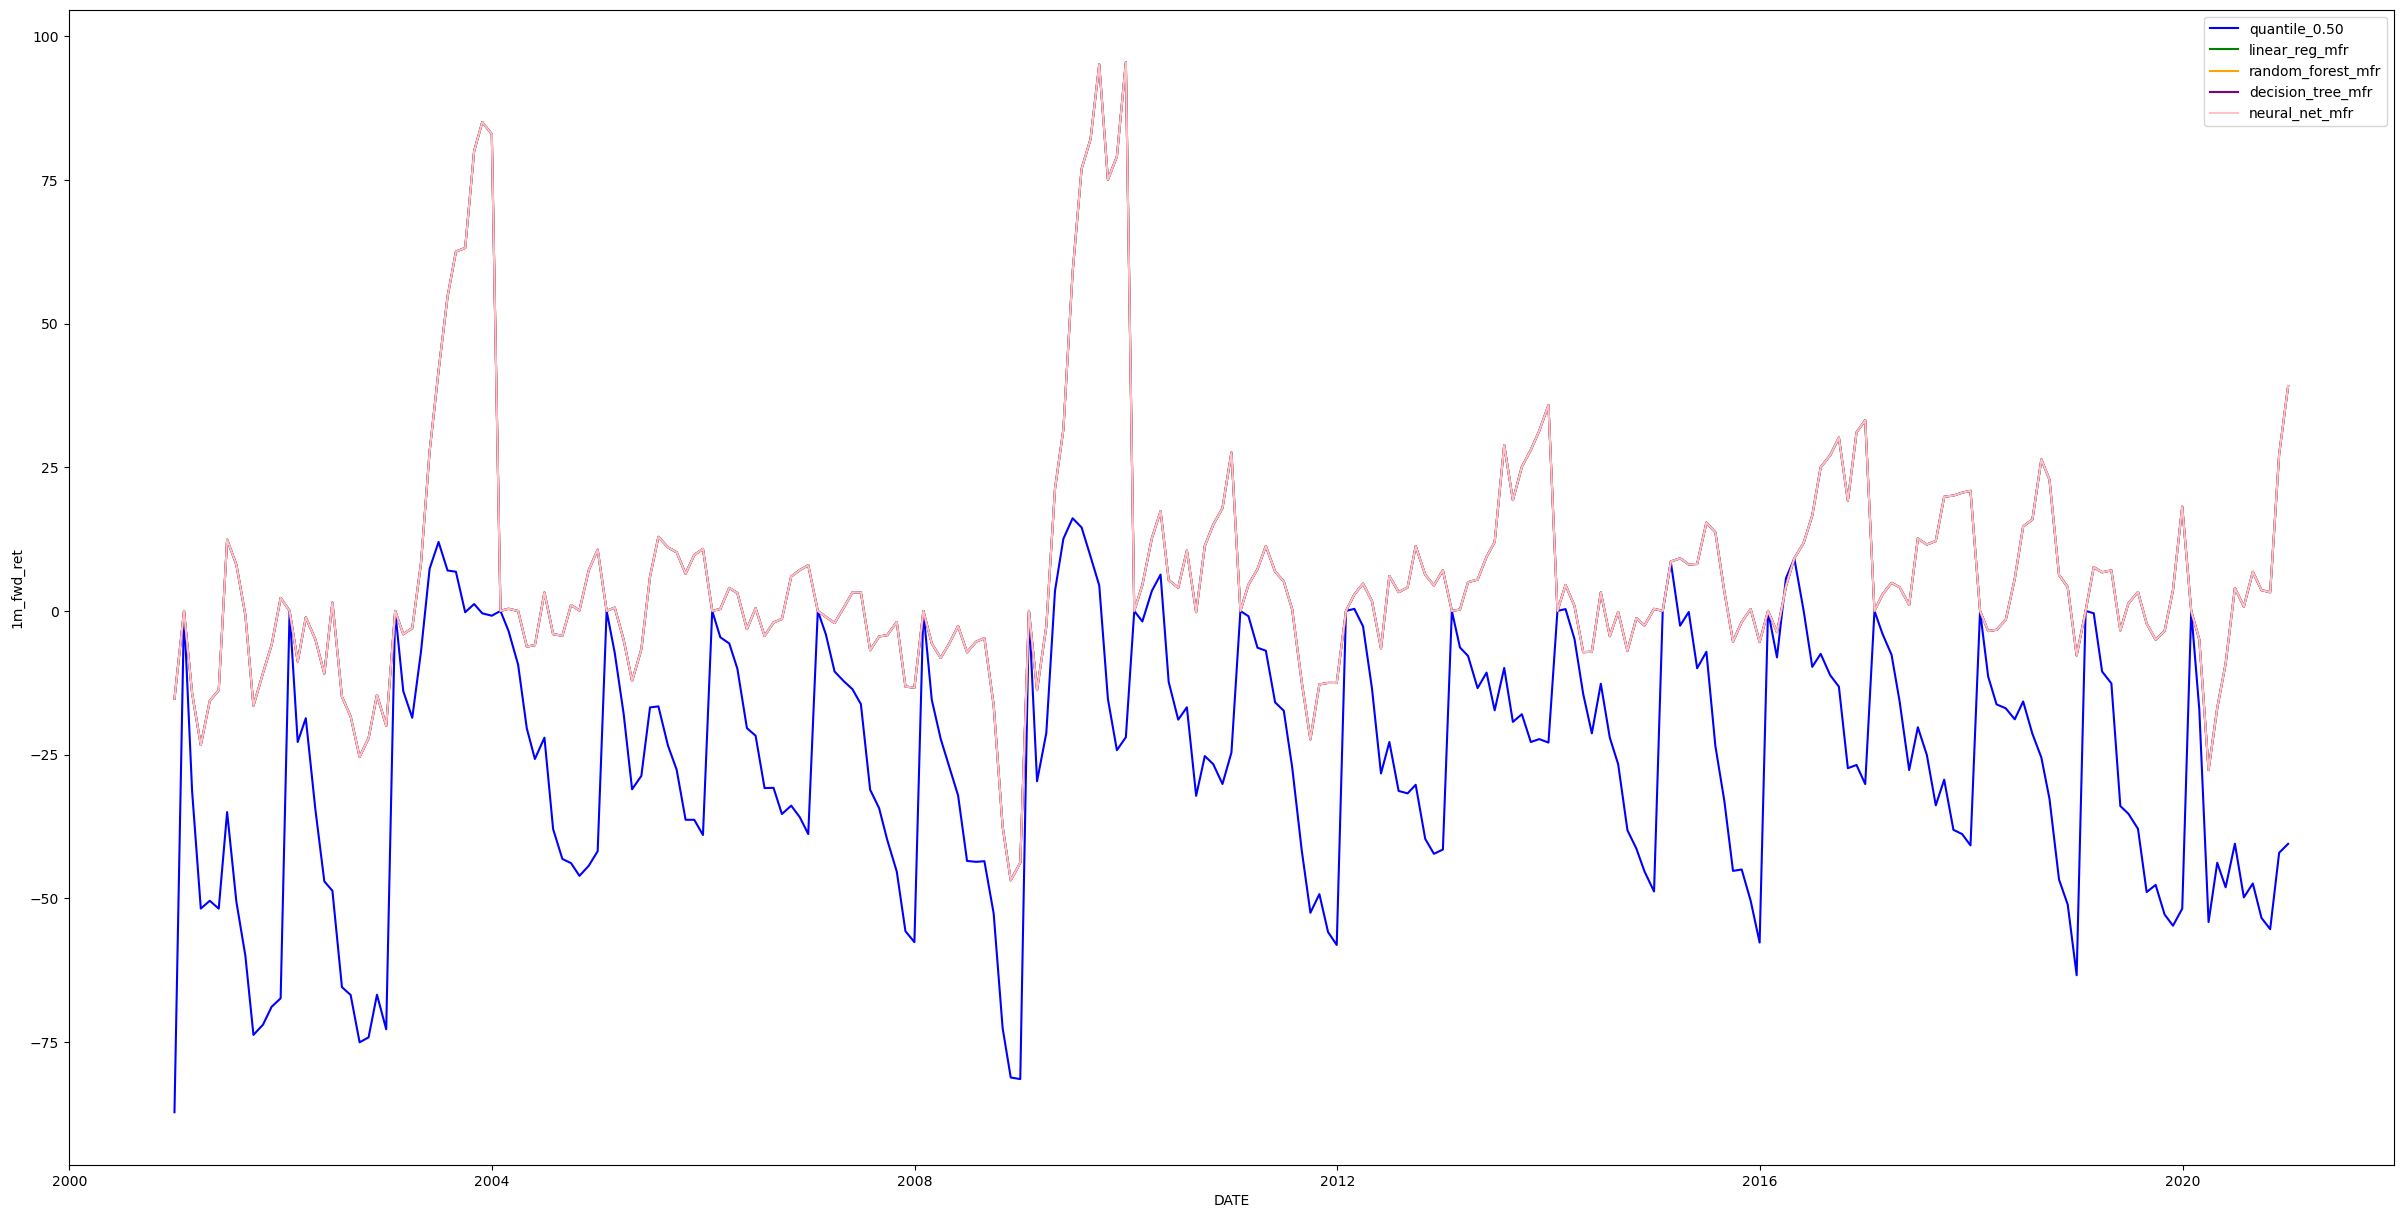

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize = (30,15))

# Define a list of colors
colors = ['blue', 'green', 'orange', 'purple', 'pink']
s_list = ['quantile_0.50','linear_reg_mfr','random_forest_mfr','decision_tree_mfr','neural_net_mfr']
for i, strat in enumerate(s_list):
    sns.lineplot(data = strategies[strat][strategies[strat]['strategy']=='short'].reset_index().groupby("DATE").agg({'1m_fwd_ret':'mean'}),x = 'DATE',y='1m_fwd_ret',color=colors[i],estimator = None)
plt.legend(s_list)
plt.show()